In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T

from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- 1. Configuration ---
# !!! IMPORTANT: Make sure this path is correct for your system !!!
DATA_DIR = Path("FakeVsRealDataset(for-rerec)/for-rerecorded")
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10
TARGET_SAMPLE_RATE = 16000
TARGET_LEN_SECS = 4

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device 💻")

Using cuda device 💻


In [4]:
# --- 2. Corrected AudioDataset Class ---
class AudioDataset(Dataset):
    def __init__(self, root_path, transform=None, target_sample_rate=TARGET_SAMPLE_RATE, target_len_secs=TARGET_LEN_SECS):
        self.root_path = Path(root_path)
        self.classes = sorted([d.name for d in self.root_path.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.files = self._get_files()
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.target_len = target_sample_rate * target_len_secs

    def _get_files(self):
        files = []
        for cls_name in self.classes:
            class_dir = self.root_path / cls_name
            for file_path in class_dir.glob("**/*.wav"):
                files.append((file_path, self.class_to_idx[cls_name]))
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            # Return a dummy tensor and label if a file is corrupted
            return torch.zeros(1, self.target_len), -1 

        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate).to(waveform.device)
            waveform = resampler(waveform)
            
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            
        if waveform.shape[1] > self.target_len:
            waveform = waveform[:, :self.target_len]
        else:
            padding = self.target_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
            
        if self.transform:
            spectrogram = self.transform(waveform)
        else:
            spectrogram = waveform

        return spectrogram, label

In [5]:
# --- 3. The Corrected AudioClassifier Model ---
class AudioClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten()
        # Corrected Input Size Calculation:
        # Spectrogram Height: 64 mels -> MaxPool(2) -> 32 -> 16 -> 8
        # Spectrogram Width: 126 time steps -> MaxPool(2) -> 63 -> 31 -> 15
        # So, flattened size is 64 channels * 8 height * 15 width = 7680
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=7680, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [6]:
# --- 4. Data Transforms and Dataloaders ---
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

train_dataset = AudioDataset(root_path=DATA_DIR / "training", transform=mel_spectrogram_transform)
val_dataset = AudioDataset(root_path=DATA_DIR / "validation", transform=mel_spectrogram_transform)
test_dataset = AudioDataset(root_path=DATA_DIR / "testing", transform=mel_spectrogram_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Found {len(train_dataset)} training files, {len(val_dataset)} validation files, {len(test_dataset)} testing files.")
print(f"Classes: {train_dataset.classes}")

Found 10208 training files, 2244 validation files, 816 testing files.
Classes: ['fake', 'real']



Visualizing a sample spectrogram...


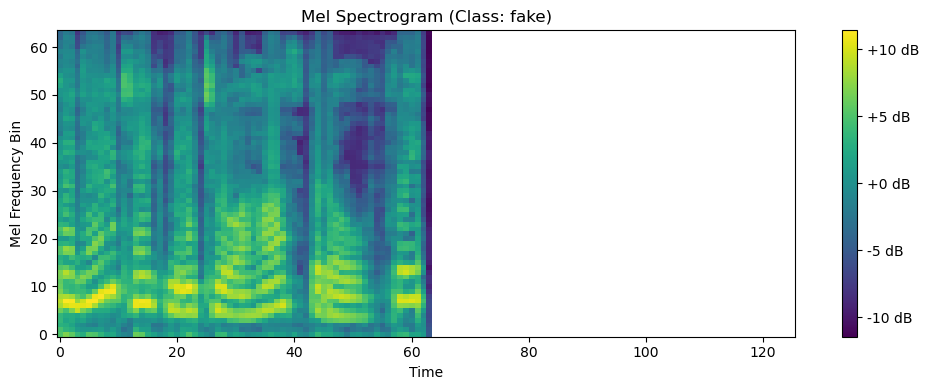

In [7]:
# --- 5. Visualize a Sample ---
print("\nVisualizing a sample spectrogram...")
spectrogram, label = train_dataset[0]
plt.figure(figsize=(10, 4))
plt.imshow(torch.log(spectrogram.squeeze()).numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.title(f"Mel Spectrogram (Class: {train_dataset.classes[label]})")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [8]:
# --- 6. Training and Evaluation Functions ---
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in tqdm(dataloader, desc="Training"):
        # This handles potential corrupted files from the dataset
        if -1 in y:
            continue
        X, y = X.to(device), y.to(device)
        y_pred_logits = model(X)
        loss = loss_fn(y_pred_logits, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        total_acc += (y_pred_class == y).sum().item() / len(y)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Evaluating"):
            if -1 in y:
                continue
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            total_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            total_acc += (y_pred_class == y).sum().item() / len(y)
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [9]:
# --- 7. Main Training Loop ---
model = AudioClassifier(num_classes=len(train_dataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting training...🚀")
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    
    print(
        f"Epoch: {epoch+1} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

print("\nTraining finished! 🎉")


Starting training...🚀


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:24<00:00,  2.95it/s]


Epoch: 1 | Train Loss: 10.7555 | Train Acc: 0.6572 | Val Loss: 0.5721 | Val Acc: 0.7262


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 13.16it/s]


Epoch: 2 | Train Loss: 0.5391 | Train Acc: 0.7469 | Val Loss: 0.4920 | Val Acc: 0.7610


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 14.20it/s]


Epoch: 3 | Train Loss: 0.4811 | Train Acc: 0.7710 | Val Loss: 0.4611 | Val Acc: 0.7865


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 14.91it/s]


Epoch: 4 | Train Loss: 0.4557 | Train Acc: 0.7849 | Val Loss: 0.4450 | Val Acc: 0.8006


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 16.37it/s]


Epoch: 5 | Train Loss: 0.4380 | Train Acc: 0.7939 | Val Loss: 0.4266 | Val Acc: 0.8037


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 16.27it/s]


Epoch: 6 | Train Loss: 0.4163 | Train Acc: 0.8068 | Val Loss: 0.4211 | Val Acc: 0.8103


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 16.41it/s]


Epoch: 7 | Train Loss: 0.3907 | Train Acc: 0.8282 | Val Loss: 0.4122 | Val Acc: 0.8239


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 16.31it/s]


Epoch: 8 | Train Loss: 0.3835 | Train Acc: 0.8310 | Val Loss: 0.4342 | Val Acc: 0.8226


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 16.63it/s]


Epoch: 9 | Train Loss: 0.3730 | Train Acc: 0.8339 | Val Loss: 0.4536 | Val Acc: 0.8222


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 17.03it/s]

Epoch: 10 | Train Loss: 0.3599 | Train Acc: 0.8376 | Val Loss: 0.4883 | Val Acc: 0.8143

Training finished! 🎉



Evaluating on the test set...


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 26/26 [00:09<00:00,  2.74it/s]



Final Test Accuracy: 0.7091


Generating Confusion Matrix: 100%|█████████████████████████████████████████████████████| 26/26 [00:01<00:00, 13.49it/s]


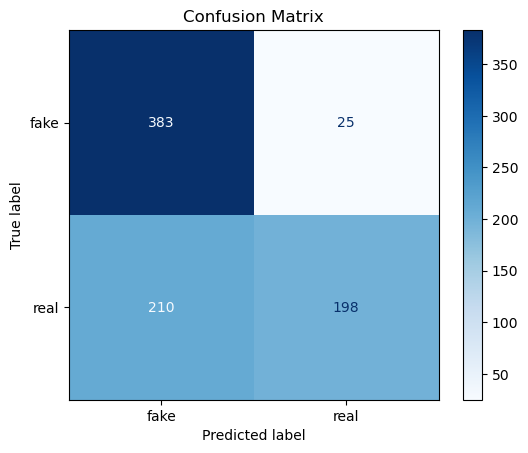

In [10]:
# --- 8. Final Test and Confusion Matrix ---
print("\nEvaluating on the test set...")
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Generating Confusion Matrix"):
        if -1 in y:
            continue
        X, y = X.to(device), y.to(device)
        y_pred_logits = model(X)
        y_pred_class = torch.argmax(y_pred_logits, dim=1)
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()